# WSI - ćwiczenie 6
## Yaroslav Harbar
### Uczenie (się) ze wzmocnieniem

Celem ćwiczenia jest implementacja algorytmu Q-learning. W tym zadaniu zostało wykorzystane środowisko *Taxi-v3*, które składa się ze świata 2D, w którym agentem jest taksówkarz, który musi odebrać klienta i wysadzić go w miejscu docelowym.

In [383]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import time
import pandas as pd

## Środowisko *Taxi-v3*

Kluczowymi elementami algorytmu Q-learning jest *stany* oraz *akcje*.
W środowisku *Taxi-v3* agent może wchodzić w interakcję z otoczeniem za pomocą następujących dyskretnych akcji: jazda do góry, jazda do dołu, jazda w prawo, jazda w lewo, zabranie pasażera i wysadzenie pasażera.

| Akcja               | Numer akcji |
|---------------------|-------------|
| jazda do góry       | 0           |
| jazda do dołu       | 1           |
| jazda w prawo       | 2           |
| jazda w lewo        | 3           |
| zabranie pasażera   | 4           |
| wysadzenie pasażera | 5           |

Natomiast stan w środowisku *Taxi-v3* jest reprezentowany jako krotka zawierająca pozycję agenta (taksówkarza), lokalizacja pasażera, który ma być odebrany oraz miejsce docelowe. State = (agent_position_x, agent_position_y, passenger_localization, destination_localization)

| Lokalizacja pasażera \ Miejsce docelowe | Numer |
|-----------------------------------------|------------|
| czerwone                                | 0          |
| zielone                                 | 1          |
| żółte                                   | 2          |
| niebieskie                              | 3          |
| w taksówce (tylko dla pasażera)         | 4          |


In [384]:
env = gym.make('Taxi-v3')
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Na rysunku jest przedstawione środowisko Taxi-v3, gdzie zielony prostokąt jest agentem, litery R, G, Y, B - reprezentują lokalizacje. Jeżeli jedna z tych liter jest pokolorowany na niebiesko, to oznacza, że w tym miejscu jest pasażer, natomiast jeżeli jest pokolorowany na różowo, to oznacza, że to jest miejsce docelowe.

## Algorytm Q-Learning
Algorytm Q-Learning działa poprzez obserwowanie gry agenta i stopniowe poprawienie jego oszacowań Q-Value. Po otrzymaniu dość dokładnych oszacowań Q-Value zadaniem optymalnej strategii jest wybór czynności o największym Q-Value. W klasie została zaimplementowana metoda **train()** oparta na algorytmie Q-learning oraz odtwarzającą wiele epizodów. Celem tej metody jest uzyskać zbieżność z optymalnymi Q-Values, które są reprezentowane jako **q_table**. Kolejną metodą jest metoda **evaluate()**, która zwraca średnią nagród po ewaluacji działającej przez **evaluate_episodes** odcinków. Metoda **exploration()** wykonuje eksploracje, wykorzystując strategie **$e$-zachłanną**: akcja losuje się spośród najlepszych z prawdopodobieństwem *1-$e$*, w innym przypadku, akcja zostanie wylosowana spośród wszystkich.

In [385]:
class QLearning:
    def __init__(self, env_name):
        self.env_name= env_name
        self.env = gym.make(env_name).env
        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.rewards_history = []

    def get_parameters(self):
        return [
            self.env_name,
            self.env,
            self.q_table,
            self.rewards_history
        ]

    def exploration(self, epsilon, state):
        if np.random.rand() > epsilon:
            return np.argmax(self.q_table[state])
        return self.env.action_space.sample()

    def train(self, train_episodes, epsilon, beta, gamma, evaluate_step, evaluate_episodes, evaluate_max_steps, print_evaluate_info=False):
        for i in range(train_episodes):
            state = self.env.reset()
            episode_reward = 0
            done = False

            while not done:
                action = self.exploration(epsilon, state)
                next_state, reward, done, info = self.env.step(action)
                self.q_table[state][action] += beta * (reward + gamma * np.max(self.q_table[next_state, :]) - self.q_table[state][action])
                state = next_state
                episode_reward += reward

            self.rewards_history.append(episode_reward)

            if i > 0 and i % evaluate_step == 0 and print_evaluate_info:
                print("Evaluate #", i // evaluate_step, ' Mean reward: ', self.evaluate(evaluate_episodes, evaluate_max_steps))

    def evaluate(self, evaluate_episodes, evaluate_max_steps):
        episodes_rewards = []
        for i in range(evaluate_episodes):
            state = self.env.reset()
            episode_reward = 0

            for _ in range(evaluate_max_steps):
                action = np.argmax(self.q_table[state])
                next_state, reward, done, info = self.env.step(action)
                state = next_state
                episode_reward += reward

                if done:
                    break
            episodes_rewards.append(episode_reward)

        return np.mean(episodes_rewards)

|Dla wygodniejszego badania wpływu parametrów na działania algorytmu Q-learning, stworzyłem klasę **Simulation**, która za pomocą metody **simulate** przeprowadza symulacje i zwraca wykres zbieżności algorytmu Q-Learning przy podanych parametrach.

In [386]:
class Simulation:
    def __init__(self):
        self.simulation_list = []

    def get_parametrs(self):
        return [self.simulation_list]

    def simulate(self, train_episodes, epsilon, beta, gamma, evaluate_step, evaluate_episodes, evaluate_max_steps=10000,print_evaluate_info=False):
        qL = QLearning("Taxi-v3")

        start_time = time.time()
        qL.train(train_episodes, epsilon, beta, gamma, evaluate_step, evaluate_episodes, evaluate_max_steps, print_evaluate_info)
        end_time = time.time()

        self.simulation_list.append([train_episodes, epsilon, beta, gamma, qL.evaluate(evaluate_episodes, evaluate_max_steps), end_time - start_time])

        plt.plot(qL.rewards_history)
        plt.show()

    def get_simulation_table(self):
        return pd.DataFrame(self.simulation_list, columns=["episodes", "epsilon", "beta", "gamma", "evaluation", "train time"])


## Symulacja
Najpierw sprawdzam działanie zaimplementowanego Q-Learning algorytmu dla początkowych parametrów: współczynnik uczenia (beta) = 0,05, stopa dyskontowa (gamma) = 0,9, epsilon=0,8

In [387]:
simulation = Simulation()

### Badanie wpływu epsilon
Wartość e = 0,8 jest dość duża

Evaluate # 1  Mean reward:  -1192.69
Evaluate # 2  Mean reward:  8.04
Evaluate # 3  Mean reward:  7.79
Evaluate # 4  Mean reward:  7.74
Evaluate # 5  Mean reward:  8.08
Evaluate # 6  Mean reward:  7.87
Evaluate # 7  Mean reward:  8.07
Evaluate # 8  Mean reward:  8.08
Evaluate # 9  Mean reward:  7.98


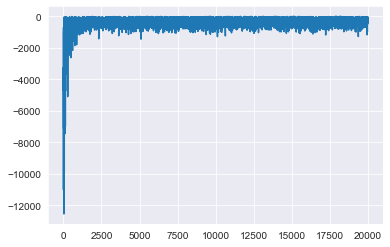

In [388]:
simulation.simulate(train_episodes=20000, epsilon=0.8, beta=0.05, gamma=0.9, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Dlatego zmniejszam wartość epsilon, żeby osiągnąć lepszy wynik

Evaluate # 1  Mean reward:  -2893.61
Evaluate # 2  Mean reward:  -291.75
Evaluate # 3  Mean reward:  -92.35
Evaluate # 4  Mean reward:  7.92
Evaluate # 5  Mean reward:  7.43
Evaluate # 6  Mean reward:  7.88
Evaluate # 7  Mean reward:  8.28
Evaluate # 8  Mean reward:  7.84
Evaluate # 9  Mean reward:  8.09


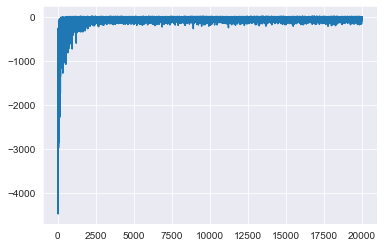

In [389]:
simulation.simulate(train_episodes=20000, epsilon=0.5, beta=0.05, gamma=0.9, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Evaluate # 1  Mean reward:  -4394.55
Evaluate # 2  Mean reward:  -992.53
Evaluate # 3  Mean reward:  7.65
Evaluate # 4  Mean reward:  7.69
Evaluate # 5  Mean reward:  8.09
Evaluate # 6  Mean reward:  8.02
Evaluate # 7  Mean reward:  7.78
Evaluate # 8  Mean reward:  7.37
Evaluate # 9  Mean reward:  8.07


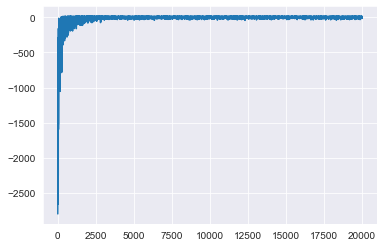

In [390]:
simulation.simulate(train_episodes=20000, epsilon=0.1, beta=0.05, gamma=0.9, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Evaluate # 1  Mean reward:  -7194.82
Evaluate # 2  Mean reward:  -992.61
Evaluate # 3  Mean reward:  -292.39
Evaluate # 4  Mean reward:  7.85
Evaluate # 5  Mean reward:  7.81
Evaluate # 6  Mean reward:  7.9
Evaluate # 7  Mean reward:  7.56
Evaluate # 8  Mean reward:  7.87
Evaluate # 9  Mean reward:  8.01


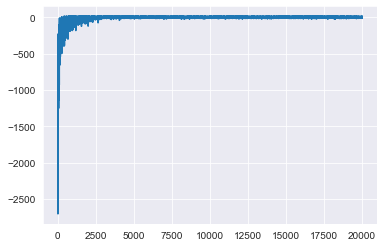

In [391]:
simulation.simulate(train_episodes=20000, epsilon=0.05, beta=0.05, gamma=0.9, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Evaluate # 1  Mean reward:  -4894.97
Evaluate # 2  Mean reward:  -492.16
Evaluate # 3  Mean reward:  -92.44
Evaluate # 4  Mean reward:  7.87
Evaluate # 5  Mean reward:  7.87
Evaluate # 6  Mean reward:  7.67
Evaluate # 7  Mean reward:  8.26
Evaluate # 8  Mean reward:  7.81
Evaluate # 9  Mean reward:  7.56


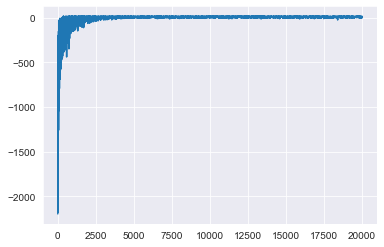

In [392]:
simulation.simulate(train_episodes=20000, epsilon=0.01, beta=0.05, gamma=0.9, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Widać, że zmniejszenie epsilon prowadzi do lepszej zbieżności algorytmy. Najlepszy wynik został uzyskany przy epsilon 0,01

### Badanie wpływu współczynnika uczenia

Evaluate # 1  Mean reward:  -1092.16
Evaluate # 2  Mean reward:  7.43
Evaluate # 3  Mean reward:  8.4
Evaluate # 4  Mean reward:  7.75
Evaluate # 5  Mean reward:  8.06
Evaluate # 6  Mean reward:  8.12
Evaluate # 7  Mean reward:  7.67
Evaluate # 8  Mean reward:  8.07
Evaluate # 9  Mean reward:  7.64


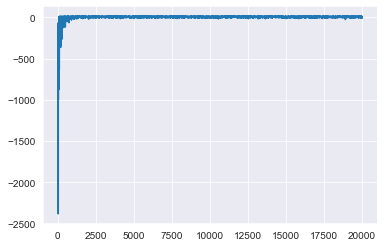

In [393]:
simulation.simulate(train_episodes=20000, epsilon=0.01, beta=0.2, gamma=0.9, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Evaluate # 1  Mean reward:  -1593.11
Evaluate # 2  Mean reward:  7.82
Evaluate # 3  Mean reward:  7.93
Evaluate # 4  Mean reward:  7.85
Evaluate # 5  Mean reward:  7.82
Evaluate # 6  Mean reward:  8.1
Evaluate # 7  Mean reward:  8.32
Evaluate # 8  Mean reward:  8.15
Evaluate # 9  Mean reward:  7.89


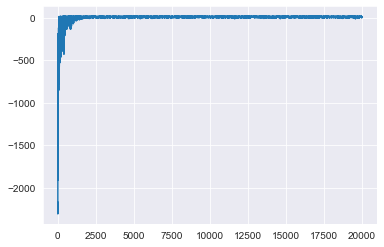

In [394]:
simulation.simulate(train_episodes=20000, epsilon=0.01, beta=0.1, gamma=0.9, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Evaluate # 1  Mean reward:  -5095.03
Evaluate # 2  Mean reward:  -1692.4
Evaluate # 3  Mean reward:  -192.09
Evaluate # 4  Mean reward:  7.87
Evaluate # 5  Mean reward:  8.25
Evaluate # 6  Mean reward:  7.9
Evaluate # 7  Mean reward:  7.8
Evaluate # 8  Mean reward:  8.0
Evaluate # 9  Mean reward:  8.12


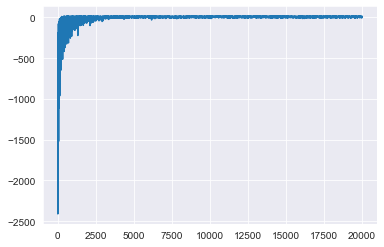

In [395]:
simulation.simulate(train_episodes=20000, epsilon=0.01, beta=0.05, gamma=0.9, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Evaluate # 1  Mean reward:  -11699.88
Evaluate # 2  Mean reward:  -16798.37
Evaluate # 3  Mean reward:  -6896.64
Evaluate # 4  Mean reward:  -6695.76
Evaluate # 5  Mean reward:  -8093.53
Evaluate # 6  Mean reward:  -4193.86
Evaluate # 7  Mean reward:  -5093.21
Evaluate # 8  Mean reward:  -3193.39
Evaluate # 9  Mean reward:  -892.16


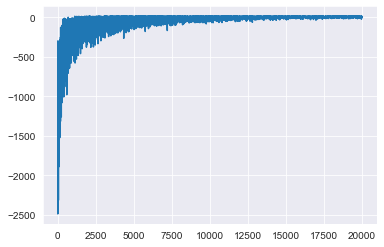

In [396]:
simulation.simulate(train_episodes=20000, epsilon=0.01, beta=0.01, gamma=0.9, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Widać, że zmniejszenie współczynnika uczenia nie powoduje jakichś znaczących ulepszenia wyniku. Po zmniejszenia tej wartości do 0,01 otrzymałem znaczące pogorszenie wyniku. Dlatego najlepsza zbieżność została uzyskana przy wartości współczynnika równym 0,05.

### Badanie wpływu stopy dyskontowej
Jeżeli stopa dyskontowa będzie bliska zeru, to przyszłe nagrody nie będą się liczyć się znacząco w porównaniu do bieżących. Odwrotnie jest, gdy ta wartość jest bliska do 1. Dlatego typowe wartości tego parametru są od 0,9 do 0,99.

Evaluate # 1  Mean reward:  -7894.06
Evaluate # 2  Mean reward:  -592.37
Evaluate # 3  Mean reward:  7.93
Evaluate # 4  Mean reward:  8.07
Evaluate # 5  Mean reward:  7.11
Evaluate # 6  Mean reward:  8.5
Evaluate # 7  Mean reward:  8.3
Evaluate # 8  Mean reward:  8.08
Evaluate # 9  Mean reward:  7.9


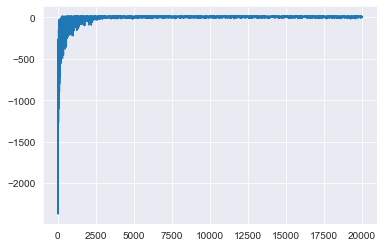

In [397]:
simulation.simulate(train_episodes=20000, epsilon=0.01, beta=0.05, gamma=0.95, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Evaluate # 1  Mean reward:  -4394.64
Evaluate # 2  Mean reward:  -192.36
Evaluate # 3  Mean reward:  7.94
Evaluate # 4  Mean reward:  8.14
Evaluate # 5  Mean reward:  8.13
Evaluate # 6  Mean reward:  8.12
Evaluate # 7  Mean reward:  8.14
Evaluate # 8  Mean reward:  7.81
Evaluate # 9  Mean reward:  7.75


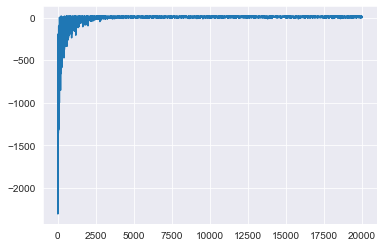

In [398]:
simulation.simulate(train_episodes=20000, epsilon=0.01, beta=0.05, gamma=0.99, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Sprawdzę teraz, co będzie, jeżeli gamma będzie mniejsza niż 0,9

Evaluate # 1  Mean reward:  -7297.08
Evaluate # 2  Mean reward:  -3493.88
Evaluate # 3  Mean reward:  -3094.19
Evaluate # 4  Mean reward:  -1592.74
Evaluate # 5  Mean reward:  -1592.64
Evaluate # 6  Mean reward:  -1292.88
Evaluate # 7  Mean reward:  -1193.02
Evaluate # 8  Mean reward:  -1092.7
Evaluate # 9  Mean reward:  -1293.07


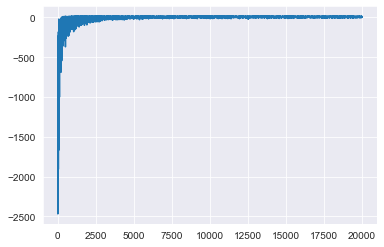

In [399]:
simulation.simulate(train_episodes=20000, epsilon=0.01, beta=0.05, gamma=0.7, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Evaluate # 1  Mean reward:  -9098.92
Evaluate # 2  Mean reward:  -6796.63
Evaluate # 3  Mean reward:  -5896.05
Evaluate # 4  Mean reward:  -4294.81
Evaluate # 5  Mean reward:  -3594.26
Evaluate # 6  Mean reward:  -2894.11
Evaluate # 7  Mean reward:  -3394.01
Evaluate # 8  Mean reward:  -1993.93
Evaluate # 9  Mean reward:  -1192.86


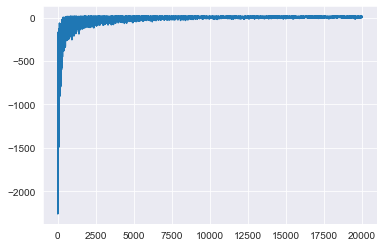

In [400]:
simulation.simulate(train_episodes=20000, epsilon=0.01, beta=0.05, gamma=0.4, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Jak widać, po zmniejszeniu wartości stopy dyskontowej, jakość wyniku się pogorszył. Jeżeli stopa dyskontowa będzie bliska zeru, to przyszłe nagrody nie będą liczyć się znacząco w porównaniu do bieżących nagród. Natomiast w przypadku wartości tego parametru bliskiej do jedynki przyszłe nagrody będą miały niemal takie samo znaczenie jak nagrody bieżące.

Sprawdzimy teraz jak wpłynie zmiana parametru epsilon po dobraniu parametrów beta oraz gamma.

Evaluate # 1  Mean reward:  -3794.03
Evaluate # 2  Mean reward:  -392.26
Evaluate # 3  Mean reward:  -192.35
Evaluate # 4  Mean reward:  8.03
Evaluate # 5  Mean reward:  8.24
Evaluate # 6  Mean reward:  8.47
Evaluate # 7  Mean reward:  7.61
Evaluate # 8  Mean reward:  8.16
Evaluate # 9  Mean reward:  8.29


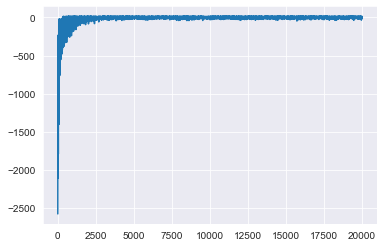

In [401]:
simulation.simulate(train_episodes=20000, epsilon=0.1, beta=0.05, gamma=0.95, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Evaluate # 1  Mean reward:  -3694.11
Evaluate # 2  Mean reward:  -91.72
Evaluate # 3  Mean reward:  7.82
Evaluate # 4  Mean reward:  7.89
Evaluate # 5  Mean reward:  8.08
Evaluate # 6  Mean reward:  8.35
Evaluate # 7  Mean reward:  8.27
Evaluate # 8  Mean reward:  7.73
Evaluate # 9  Mean reward:  8.09


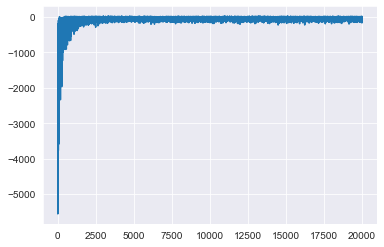

In [402]:
simulation.simulate(train_episodes=20000, epsilon=0.5, beta=0.05, gamma=0.95, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

Evaluate # 1  Mean reward:  -992.47
Evaluate # 2  Mean reward:  7.41
Evaluate # 3  Mean reward:  7.26
Evaluate # 4  Mean reward:  7.77
Evaluate # 5  Mean reward:  7.81
Evaluate # 6  Mean reward:  7.47
Evaluate # 7  Mean reward:  7.7
Evaluate # 8  Mean reward:  8.5
Evaluate # 9  Mean reward:  8.38


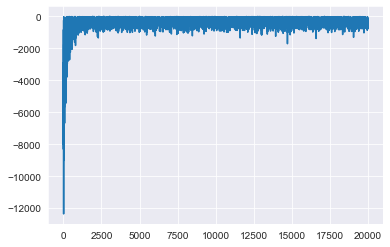

In [403]:
simulation.simulate(train_episodes=20000, epsilon=0.8, beta=0.05, gamma=0.95, evaluate_step=2000, evaluate_episodes=100, evaluate_max_steps=10000, print_evaluate_info=True)

In [404]:
simulation.get_simulation_table()

,episodes,epsilon,beta,gamma,evaluation,train time
0,20000,0.80,0.05,0.90,8.00,50.982064
1,20000,0.50,0.05,0.90,7.71,22.732774
2,20000,0.10,0.05,0.90,7.88,18.335868
3,20000,0.05,0.05,0.90,7.71,18.446591
4,20000,0.01,0.05,0.90,8.06,18.616273
5,20000,0.01,0.20,0.90,7.68,9.716368
6,20000,0.01,0.10,0.90,7.73,11.322093
7,20000,0.01,0.05,0.90,8.11,17.695140
8,20000,0.01,0.01,0.90,-592.16,74.700459
9,20000,0.01,0.05,0.95,7.95,13.729129


# Wnioski
Analizując wyniki w powyższej tabeli, widzimy, że na jakość oraz czas uczenia się algorytmu wpływają kilka parametrów, a mianowicie wielkość epizodów uczenia się, wartości epsilon, beta, gamma i wielkość epizodów ewaluacji. Zwiększenie wartości epsilonu powoduje zwiększenie czasu uczenia się, lecz nie powoduje jakichś znaczących zmian w wytrenowanym modelu. Zauważyłem też, że im większa jest wartość epsilon, tym jest większe prawdopodobieństwo otrzymania lepszego rezultatu za mniejszą ilość epizodów. Na przykład porównując wyniki uzyskane w symulacjach **13-15** widać, że dla epsilonu równym **0,8** pozytywni wynik otrzymujemy już podczas drugiej ewaluacji, dla epsilonu **0,5** podczas trzeciej ewaluacji, a dla epsilonu **0,1** podczas czwartej ewaluacji.
Duży wpływ na końcowy wynik ma współczynnik uczenia (beta). Przy zmniejszeniu wartości tego współczynnika od **0,2** do **0,05** wynik końcowej ewaluacji się zwiększa od **7,68** do **8,11**, natomiast widać też, że zwiększa się czas uczenia od **9,716s** do **17,695s**. Po zmniejszeniu współczynnika uczenia do wartości **0,01** wynik znacząco się pogorszył.
Kolejnym znaczącym parametrem jest wartość stopy dyskontowej (gamma). Analizując wyniki, widać, że zmiana gamma od **0,9** do **0,99** nie powoduję znaczących zmian w wyniku końcowej ewaluacji. Natomiast kiedy gamma jest równa np. **0,5** czy **0,7** to czas oraz wynik ewaluacji jest gorszy w porównaniu np. do gammy równej **0,9** - **0,99**.
Najlepszymi parametrami pod względem jakości oraz czasu trenowania (z okresowymi ewaluacjami) są takie: epsilon=**0,01**, beta=**0,05** oraz gamma=**0,99**.